# K-Nearest Neighbors Homework Solutions
***
**Name : Prashil Bhimani** 
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [3]:
data = Numbers("../data/mnist.pklz")

In [4]:
#Printing the shape to get the values
print(data.train_x.shape)
print(data.test_y.shape)

(50000, 784)
(10000,)


Here is the analysis of the MNIST dataset.
1. There are **50,000 examles in trainig data**
2. There are **784 features in each examples**
3. There **test data size is 10,000**

### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [5]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """
        
        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()
        
    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is  
        the number of times that label y appears in the training set. 
        """
        d={}
        for i in self._y:
            if i in d:
                d[i]=d[i]+1
            else:
                d[i]=1
        return d

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties 
        by choosing the tied label that appears most often in the training data. 

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        d={}
        #Creating a dict to store the lable count in neighbours
        for n in neighbor_indices:
            if self._y[n] in d:
                d[self._y[n]]=d[self._y[n]]+1
            else:
                d[self._y[n]]=1
        
        #Maximum number of times a label is occuring
        maximum=max(d.values())
        
        #labels which occur those many time
        max_label=[]
        for i in d.keys():
            if d[i]>maximum:
                maximum=d[i]
        for i in d.keys():
            if d[i]==maximum:
                max_label.append(i)
                
        #Sort the labels who are max in the neighbour indices by their values in the count dict of the class
        max_label = sorted(max_label, key=lambda x: self._counts[x], reverse=True)

        #return the 1st element
        return max_label[0]
    

    def classify(self, example):
        """
        Given an example, return the predicted label. 

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        
        #Get k labels as a list of list (For multiple examples) to get their distances and indices in the kdTree or Training examples 
        dist, ind=self._kdtree.query([example], k=self._k) 
        return self.majority(ind[0])


    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an 
        example with true label ii was labeled as jj.

        :param test_x: test data 
        :param test_y: true test labels 
        """
        
        C = np.zeros((10,10), dtype=int)
        for xx, yy in zip(test_x, test_y):
            predicted_label=self.classify(xx)
            C[yy][predicted_label]=C[yy][predicted_label]+1
        
        return C 
            
    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.
        
        :param C: a confusion matrix 
        """
        
        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [6]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.344s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [7]:
training_example={}

#Knearest objects for various size of training examples
for i in range(5000,15000,500):
    training_example[i]=Knearest(data.train_x[0:i],data.train_y[0:i])


In [8]:
accuracy_training_example={}
#Fining the accuracy
for i in training_example.keys():
    accuracy_training_example[i]=Knearest.accuracy(training_example[i].confusion_matrix(data.test_x[0:1000],data.test_y[0:1000]))


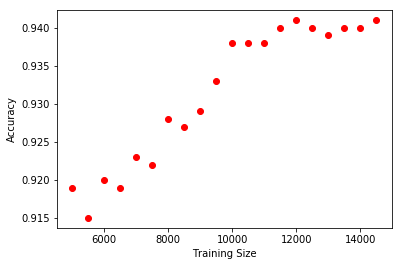

In [9]:
#Pre Processing to plot the graphs

#Seperating training example and accuracy
lists = sorted(accuracy_training_example.items()) 
training_size, accuracy = zip(*lists) # unpack a list of pairs into two tuples

#Plot the graph
plt.plot(training_size, accuracy,"ro")

#Plot properties
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.show()

**Report Part A** 

The trend is very clear here. As we increase the number of training examples the **accuracy increases**. As the number of training examples are increasing we see that the **improvement slowly tapers off**. One more thing to consider while increasing the training size is that more the training size more time will the KNN classifier take to classify your test point as it will have to compare it with more number of points. As we know that a naive KNN will calculate the distance of the test point with every point in the training point. I am not sure about how KDTree handles it. It will be definitely more efficient than that but still basic intution and observation when running it for larger training set will atleast take some more time. So it is a tradeoff in the end. If you are satisfied with the accuracy then there may be no point to **increase the size of the training size as it will only slow down your classifier.**

**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [10]:
training_example={}

#Knearest objects for various size of training examples
for i in range(5000,26000,5000):
    training_example[i]=Knearest(data.train_x[0:i],data.train_y[0:i])


In [11]:
#Running those objects with various sizes of k to test the accuracy
accuracy_training_example={}
for i in training_example.keys():
    accuracy_training_example[i]={}
    for j in range(1,11):
        training_example[i]._k=j
        #Fining the accuracy
        x=Knearest.accuracy(training_example[i].confusion_matrix(data.test_x[0:1000],data.test_y[0:1000]))
        accuracy_training_example[i][j]=x
        
        

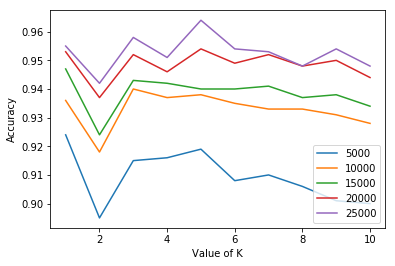

In [12]:
#Pre Processing to plot the graphs

#Seperating for each training example
lists = sorted(accuracy_training_example.items()) 
training_size, k_wise_accuracy = zip(*lists)

#create 2d list of accuracy for each 
accuracy_list=[]
for i in k_wise_accuracy:
    k,accuracy_for_each_k=zip(*sorted(i.items()))
    accuracy_list.append(list(accuracy_for_each_k))

k=range(1, 11)

#Plot each row(1 particulary training size)
for j in accuracy_list:
    plt.plot(k,j)
plt.legend(range(5000,26000,5000))

#Plot properties
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

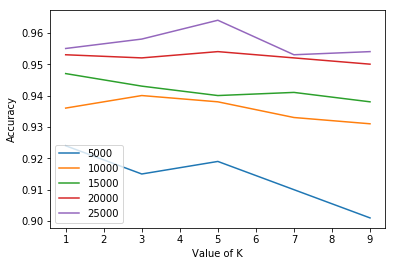

In [13]:
k=range(1, 11,2)

#Plot each row when only odd k(1 particulary training size)
for j in accuracy_list:
    plt.plot(k,j[0::2])
plt.legend(range(5000,26000,5000))

#Plot properties
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**Report Part B**
The trend is a bit more difficult to plot here. As we can see that there is a **constant dip for all training examples when k=2**. This is because as there will be a lot of conflicts when there are only 2 points. As our conflict resolution is naive and not sophisticated so as to get increase k or take a weighted k there are many misclassified points. Hence we can neglect the point for k=2 as a special case. We can also see that the **maximum accuracy for a various k depends on the size of the training examples**. When the training size is 5000 the maximum accuracy is at k=1. But for training size of 10000 and 15000 the accuracy is the most at k=3 and similary for k=5 when the training size is 20000 and 25000. This can be explained simply by the fact the more training point the more will be the density of that particular point near tthe test point. For a given radius when training size is 5000 and 25000 the density will be 5 times in 25000 than that in 5000. Hence higher the training size the bigger the k is better. Also we notice that **after a particular value the accuracy again decreases** as there will be more points in the neighbourhood with different labels hence decreasing the accuracy.

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

In [14]:
k=Knearest(data.train_x[0:20000],data.train_y[0:20000])

#Basic confusion matrix (It was redundant for me but I did not want to lose any points for that)
C1=k.confusion_matrix(data.test_x[0:1000],data.test_y[0:1000])
print(C1)
#Modified Confusion Matrix to store the index misclassified points
C = []
for i in range(0,10):
    C.append([])
    for j in range(0,10):
        C[i].append([])
for i in range(0,1000):
    predicted_label=k.classify(data.test_x[i])
    true_label=data.test_y[i]
    if true_label!=predicted_label:
        C[true_label][predicted_label].append(i)

[[ 98   1   0   0   0   0   1   0   0   0]
 [  0 106   0   0   0   0   0   1   0   0]
 [  0   2  87   1   0   0   0   2   0   1]
 [  0   0   1  98   0   1   0   0   2   3]
 [  0   1   0   0  84   0   0   0   0   4]
 [  0   0   0   0   0  88   0   1   0   2]
 [  1   1   0   0   0   0 102   0   0   0]
 [  0   2   1   0   0   0   0 102   0   1]
 [  0   2   0   4   0   1   0   1  98   1]
 [  2   0   0   1   1   0   0   3   0  91]]


In [15]:
#print(C)
errors=[]
for i in range(len(C)):
    for j in range(len(C[i])):
        if i!=j and len(C[i][j])>1:
            #Stores [true_label,predicted_label,[index of misclassified points]]
            errors.append([i,j,C[i][j]])
    
errors=sorted(errors, key=lambda x: len(x[2]), reverse=True)
print(errors)

[[4, 9, [134, 712, 819, 917]], [8, 3, [258, 274, 514, 714]], [3, 9, [212, 369, 431]], [9, 7, [329, 462, 522]], [2, 1, [368, 642]], [2, 7, [229, 756]], [3, 8, [403, 417]], [5, 9, [202, 734]], [7, 1, [359, 426]], [8, 1, [246, 429]], [9, 0, [78, 239]]]


In [16]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
    


True label : 4
Predicted label : 9


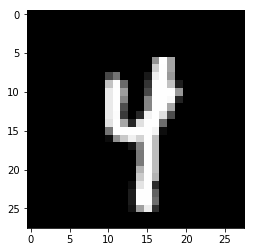

In [17]:
#plotting some of the common examples of misclassified points
view_digit(data.test_x[errors[0][2][0]])
print("True label : "+str(errors[0][0]))
print("Predicted label : "+str(errors[0][1]))

This may be misclassified because the shape is pretty close to that of 9 barring just the top joining pixels 

True label : 8
Predicted label : 3


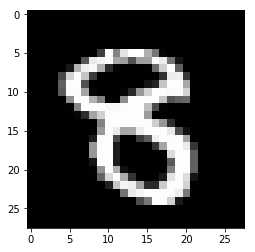

In [18]:
#plotting some of the common examples of misclassified points
view_digit(data.test_x[errors[1][2][0]])
print("True label : "+str(errors[1][0]))
print("Predicted label : "+str(errors[1][1]))

This point is weirdly misclassified and maybe a different k value might have given a better result

True label : 3
Predicted label : 9


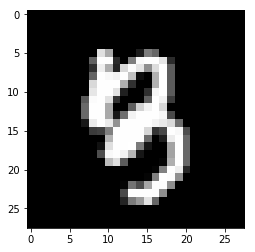

In [19]:
#plotting some of the common examples of misclassified points
view_digit(data.test_x[errors[2][2][0]])
print("True label : "+str(errors[2][0]))
print("Predicted label : "+str(errors[2][1]))

This just seems to be the case of bad handwriting. I would have been surprised if they had classified this correctly. The 3 is rotated and the top part of 9 is joined making just the top part similar to that of 9.

True label : 9
Predicted label : 7


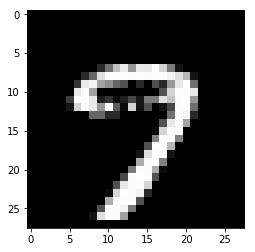

In [20]:
#plotting some of the common examples of misclassified points
view_digit(data.test_x[errors[3][2][0]])
print("True label : "+str(errors[3][0]))
print("Predicted label : "+str(errors[3][1]))

Here the pixels in the bottom part of the circle in 9 have faded and hence it appears as a 7. A better image/scanning quality would have led to better results